# TODO

- cell type placeholders
- get GM12878 results
- iteratively add in TFs and observe 1 TF prediction accuracy
- Look into MSA

## Dependency imports

In [129]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# for loading in validation file
import pandas as pd

# for metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import scipy
    
sys.path.append("../tfti")
import tfti

# Getting Required Files for Validation

/data/deepseavalidation.txt has been processed from valid.mat in the deepsea dataset. This is a raw text file of the data.

In [158]:
# TODO: user configures
tmp_dir = "/data/epitome/tmp/"
validation_file = os.path.join(tmp_dir, "deepsea_train/valid.mat")

if not os.path.isfile(validation_file):
     raise ValueError("%s cannot be found." % validation_file)
        

## Pipeline utility functions

In [131]:
##############################
#         HELPER FNS         #
##############################

def get_init_op():
    """Returns an initialization op."""
    global_init_op = tf.global_variables_initializer()
    local_init_op = tf.local_variables_initializer()
    return tf.group(global_init_op, local_init_op)

def get_session(is_interactive=True, **kwargs):
    """Returns a session."""
    config = tf.ConfigProto(
        log_device_placement=True,
        allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    if is_interactive:
        return tf.InteractiveSession(config=config, **kwargs)
    else:
        return tf.Session(config=config, **kwargs)

def restore_from_checkpoint(session, ckpt_dir=None):
    """Restores session from checkpoint."""
    if ckpt_dir is None:
        tf.logging.warn("Value for argument ckpt_dir is `None`. "
                        "Not restoring from checkpoint.")
    else:
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(
            ckpt_dir).model_checkpoint_path
        saver.restore(session, ckpt)
        
def initialize_variables(session, ckpt_dir=None):
    """Initializes global and local variables."""
    init_op = get_init_op()
    session.run(init_op)
    restore_from_checkpoint(
        session=sess,
        ckpt_dir=ckpt_dir,
    )
    
def prepare_pipeline(problem_name,
                     model_name,
                     hparams_set,
                     hparams_overrides_str,
                     data_dir="None",
                     mode=tf.estimator.ModeKeys.EVAL):
    """Returns a tuple: (problem, model, hparams)."""
    problem = registry.problem(problem_name)
    problem.get_feature_encoders()  # Creates encoders.
    hparams = trainer_lib.create_hparams(
        hparams_set, hparams_overrides_str, data_dir, problem_name)
    model = registry.model(model_name)(hparams, mode)
    return problem, model, hparams

def get_latents_and_metrics_weights(problem, targets, keep_mask):
    """Creates latents and weights."""
    metrics_mask = tf.to_float(tf.logical_not(keep_mask))
    float_keep_mask = tf.to_float(keep_mask)
    latents = tf.to_int32(
        float_keep_mask * tf.to_float(targets)
        + (1.0 - float_keep_mask) * problem.unk_id)
    return latents, metrics_mask

## Main body call

* Redefine the `get_raw_data_generator` to yield raw inputs.
* Also define `keep_mask` for deterministic masking/imputations.

In [161]:
##############################
#         MAIN BODY          #
##############################

# Parameters
problem_name="genomics_binding_deepsea_gm12878"
model_name="tfti_transformer"
hparams_set="tfti_transformer_debug" 
hparams_overrides_str=""
ckpt_dir=None  # No checkpoint.
batch_size=1  # For batch parallelism. TODO this is not efficient, nor is it correct

def get_raw_data_generator(problem):
    """Yields raw inputs and targets.
    
    Yields:
        Tuples containing:
            inputs: NACTG strings of length 1000.
            targets: An binary label array of length 919.
    """
    # load in DEV data
    tmp = scipy.io.loadmat(validation_file)
    inputs = tmp["validxdata"]
    targets = tmp["validdata"]
    for i in range(inputs.shape[0]):
        yield problem.stringify(inputs[i].transpose([1, 0])), targets[i]

# Reset graph for consistency.
tf.reset_default_graph()

# Construct pipeline.
problem, model, hparams = prepare_pipeline(
    problem_name, model_name, hparams_set, hparams_overrides_str)

# AM TODO define mask by cell type
keep_mask = np.random.choice(2, 35).astype(bool)  # Deterministic mask.

# During evaluation, we test on a new cell type
dev_cell_type_1 = 'H1-hESC' # TODO 
dev_cell_type_2 = 'GM12878'


# Shapes for preprocessed inputs/targets/latents.
preprocessed_input_sequence_length = int(np.ceil(problem.input_sequence_length / problem.chunk_size))
preprocessed_num_binary_predictions = len(problem.targets_gather_indices(dev_cell_type_1, dev_cell_type_2))
targets_gather_indices = problem.targets_gather_indices (dev_cell_type_1, dev_cell_type_2) # testing on new cell type
tf_names_indices = problem.get_overlapping_indices_for_cell_type(dev_cell_type_1, dev_cell_type_2)[1]

def get_processed_data_generator_fn(raw_data_generator, keep_mask):
    # Reshape to rank 3 arrays/tensors.
    keep_mask = keep_mask.reshape([-1, 1, 1])
    def get_processed_data_generator():
        for raw_inputs, raw_targets in raw_data_generator:
            preprocessed_inputs = np.array(problem._encoders["inputs"].encode(raw_inputs), dtype=np.int64)
            preprocessed_targets = raw_targets[targets_gather_indices]
            # Reshape to rank 3 arrays/tensors.
            preprocessed_inputs = preprocessed_inputs.reshape([-1, 1, 1])
            preprocessed_targets = preprocessed_targets.reshape([-1, 1, 1])
            yield preprocessed_inputs, preprocessed_targets, keep_mask
    return get_processed_data_generator

# Create dataset from generator.
raw_data_generator = get_raw_data_generator(problem)
processed_data_generator_fn = get_processed_data_generator_fn(raw_data_generator, keep_mask)
ds = tf.data.Dataset.from_generator(
    processed_data_generator_fn,
    output_types=(tf.int64, tf.int64, tf.bool),
    output_shapes=(
        [preprocessed_input_sequence_length, 1, 1],
        [preprocessed_num_binary_predictions, 1, 1],
        [preprocessed_num_binary_predictions, 1, 1],
    )
)

ds = ds.repeat(1)  # Single evaluation epoch.
ds = ds.batch(batch_size)

# Create one-shot-iterator.
next_item = ds.make_one_shot_iterator().get_next()
preprocessed_inputs, preprocessed_targets, latents_keep_mask = next_item

# Create the latents from the targets and mask.
latents, metrics_mask = get_latents_and_metrics_weights(problem, preprocessed_targets, latents_keep_mask)

# Pass preprocessed features through model.
preprocessed_features = {
    "inputs": preprocessed_inputs,
    "targets": preprocessed_targets,
    "latents": latents,
    "metrics_mask": metrics_mask,
}

logits, losses = model(preprocessed_features)
predictions = tf.nn.sigmoid(logits)
labels = preprocessed_features["targets"]

# Evaluation metrics we want to use.
set_auroc, _ = tfti.set_auroc(logits, labels, preprocessed_features)
set_auprc, _ = tfti.set_auprc(logits, labels, preprocessed_features)
average_auroc, _ = tfti.average_auroc(logits, labels, preprocessed_features)
average_auprc, _ = tfti.average_auprc(logits, labels, preprocessed_features)

# Initialize weights - randomly or from checkpoint
sess = get_session(is_interactive=False)
initialize_variables(sess, ckpt_dir)

predictions_and_labels = []
try:
    while True:
        # average_auroc updates a numerator & denominator
        # and computes the average_auroc for the entire dataset.
        fetch = (predictions, labels)
        fetch_numpy = sess.run(fetch)
        predictions_and_labels.append(fetch_numpy)

except tf.errors.OutOfRangeError:
    print(f"Computed predictions for : {len(predictions_and_labels)} points")

INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.


[2018-04-26 08:44:03,975] Unsetting shared_embedding_and_softmax_weights.


INFO:tensorflow:Setting T2TModel mode to 'eval'


[2018-04-26 08:44:03,977] Setting T2TModel mode to 'eval'


INFO:tensorflow:Setting hparams.dropout to 0.0


[2018-04-26 08:44:03,978] Setting hparams.dropout to 0.0


INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0


[2018-04-26 08:44:03,979] Setting hparams.layer_prepostprocess_dropout to 0.0


INFO:tensorflow:Setting hparams.symbol_dropout to 0.0


[2018-04-26 08:44:03,981] Setting hparams.symbol_dropout to 0.0


INFO:tensorflow:Setting hparams.attention_dropout to 0.0


[2018-04-26 08:44:03,982] Setting hparams.attention_dropout to 0.0


INFO:tensorflow:Setting hparams.relu_dropout to 0.0


[2018-04-26 08:44:03,983] Setting hparams.relu_dropout to 0.0


INFO:tensorflow:Marks for CellType H1-hESC: [(259, 'H1-hESC|ATF2|None'), (260, 'H1-hESC|ATF3|None'), (261, 'H1-hESC|BCL11A|None'), (467, 'H1-hESC|BRCA1|None'), (468, 'H1-hESC|CEBPB|None'), (129, 'H1-hESC|CHD1|None'), (470, 'H1-hESC|CHD2|None'), (130, 'H1-hESC|CTCF|None'), (54, 'H1-hESC|DNase|None'), (131, 'H1-hESC|EZH2|None'), (263, 'H1-hESC|Egr-1|None'), (265, 'H1-hESC|GABP|None'), (267, 'H1-hESC|JunD|None'), (477, 'H1-hESC|Max|None'), (478, 'H1-hESC|Mxi1|None'), (269, 'H1-hESC|NRSF|None'), (479, 'H1-hESC|Nrf1|None'), (271, 'H1-hESC|Pol2-4H8|None'), (272, 'H1-hESC|Pol2|None'), (481, 'H1-hESC|RFX5|None'), (275, 'H1-hESC|RXRA|None'), (274, 'H1-hESC|Rad21|None'), (482, 'H1-hESC|SIN3A|None'), (277, 'H1-hESC|SIX5|None'), (278, 'H1-hESC|SP1|None'), (281, 'H1-hESC|SRF|None'), (282, 'H1-hESC|TAF1|None'), (484, 'H1-hESC|TBP|None'), (284, 'H1-hESC|TCF12|None'), (286, 'H1-hESC|USF-1|None'), (485, 'H1-hESC|USF2|None'), (287, 'H1-hESC|YY1|None'), (486, 'H1-hESC|Znf143|None'), (472, 'H1-hESC|c-Myc|

[2018-04-26 08:44:04,001] Marks for CellType H1-hESC: [(259, 'H1-hESC|ATF2|None'), (260, 'H1-hESC|ATF3|None'), (261, 'H1-hESC|BCL11A|None'), (467, 'H1-hESC|BRCA1|None'), (468, 'H1-hESC|CEBPB|None'), (129, 'H1-hESC|CHD1|None'), (470, 'H1-hESC|CHD2|None'), (130, 'H1-hESC|CTCF|None'), (54, 'H1-hESC|DNase|None'), (131, 'H1-hESC|EZH2|None'), (263, 'H1-hESC|Egr-1|None'), (265, 'H1-hESC|GABP|None'), (267, 'H1-hESC|JunD|None'), (477, 'H1-hESC|Max|None'), (478, 'H1-hESC|Mxi1|None'), (269, 'H1-hESC|NRSF|None'), (479, 'H1-hESC|Nrf1|None'), (271, 'H1-hESC|Pol2-4H8|None'), (272, 'H1-hESC|Pol2|None'), (481, 'H1-hESC|RFX5|None'), (275, 'H1-hESC|RXRA|None'), (274, 'H1-hESC|Rad21|None'), (482, 'H1-hESC|SIN3A|None'), (277, 'H1-hESC|SIX5|None'), (278, 'H1-hESC|SP1|None'), (281, 'H1-hESC|SRF|None'), (282, 'H1-hESC|TAF1|None'), (484, 'H1-hESC|TBP|None'), (284, 'H1-hESC|TCF12|None'), (286, 'H1-hESC|USF-1|None'), (485, 'H1-hESC|USF2|None'), (287, 'H1-hESC|YY1|None'), (486, 'H1-hESC|Znf143|None'), (472, 'H1-h

INFO:tensorflow:Marks for CellType H1-hESC: [(259, 'H1-hESC|ATF2|None'), (260, 'H1-hESC|ATF3|None'), (261, 'H1-hESC|BCL11A|None'), (467, 'H1-hESC|BRCA1|None'), (468, 'H1-hESC|CEBPB|None'), (129, 'H1-hESC|CHD1|None'), (470, 'H1-hESC|CHD2|None'), (130, 'H1-hESC|CTCF|None'), (54, 'H1-hESC|DNase|None'), (131, 'H1-hESC|EZH2|None'), (263, 'H1-hESC|Egr-1|None'), (265, 'H1-hESC|GABP|None'), (267, 'H1-hESC|JunD|None'), (477, 'H1-hESC|Max|None'), (478, 'H1-hESC|Mxi1|None'), (269, 'H1-hESC|NRSF|None'), (479, 'H1-hESC|Nrf1|None'), (271, 'H1-hESC|Pol2-4H8|None'), (272, 'H1-hESC|Pol2|None'), (481, 'H1-hESC|RFX5|None'), (275, 'H1-hESC|RXRA|None'), (274, 'H1-hESC|Rad21|None'), (482, 'H1-hESC|SIN3A|None'), (277, 'H1-hESC|SIX5|None'), (278, 'H1-hESC|SP1|None'), (281, 'H1-hESC|SRF|None'), (282, 'H1-hESC|TAF1|None'), (484, 'H1-hESC|TBP|None'), (284, 'H1-hESC|TCF12|None'), (286, 'H1-hESC|USF-1|None'), (485, 'H1-hESC|USF2|None'), (287, 'H1-hESC|YY1|None'), (486, 'H1-hESC|Znf143|None'), (472, 'H1-hESC|c-Myc|

[2018-04-26 08:44:04,022] Marks for CellType H1-hESC: [(259, 'H1-hESC|ATF2|None'), (260, 'H1-hESC|ATF3|None'), (261, 'H1-hESC|BCL11A|None'), (467, 'H1-hESC|BRCA1|None'), (468, 'H1-hESC|CEBPB|None'), (129, 'H1-hESC|CHD1|None'), (470, 'H1-hESC|CHD2|None'), (130, 'H1-hESC|CTCF|None'), (54, 'H1-hESC|DNase|None'), (131, 'H1-hESC|EZH2|None'), (263, 'H1-hESC|Egr-1|None'), (265, 'H1-hESC|GABP|None'), (267, 'H1-hESC|JunD|None'), (477, 'H1-hESC|Max|None'), (478, 'H1-hESC|Mxi1|None'), (269, 'H1-hESC|NRSF|None'), (479, 'H1-hESC|Nrf1|None'), (271, 'H1-hESC|Pol2-4H8|None'), (272, 'H1-hESC|Pol2|None'), (481, 'H1-hESC|RFX5|None'), (275, 'H1-hESC|RXRA|None'), (274, 'H1-hESC|Rad21|None'), (482, 'H1-hESC|SIN3A|None'), (277, 'H1-hESC|SIX5|None'), (278, 'H1-hESC|SP1|None'), (281, 'H1-hESC|SRF|None'), (282, 'H1-hESC|TAF1|None'), (484, 'H1-hESC|TBP|None'), (284, 'H1-hESC|TCF12|None'), (286, 'H1-hESC|USF-1|None'), (485, 'H1-hESC|USF2|None'), (287, 'H1-hESC|YY1|None'), (486, 'H1-hESC|Znf143|None'), (472, 'H1-h

INFO:tensorflow:Marks for CellType H1-hESC: [(259, 'H1-hESC|ATF2|None'), (260, 'H1-hESC|ATF3|None'), (261, 'H1-hESC|BCL11A|None'), (467, 'H1-hESC|BRCA1|None'), (468, 'H1-hESC|CEBPB|None'), (129, 'H1-hESC|CHD1|None'), (470, 'H1-hESC|CHD2|None'), (130, 'H1-hESC|CTCF|None'), (54, 'H1-hESC|DNase|None'), (131, 'H1-hESC|EZH2|None'), (263, 'H1-hESC|Egr-1|None'), (265, 'H1-hESC|GABP|None'), (267, 'H1-hESC|JunD|None'), (477, 'H1-hESC|Max|None'), (478, 'H1-hESC|Mxi1|None'), (269, 'H1-hESC|NRSF|None'), (479, 'H1-hESC|Nrf1|None'), (271, 'H1-hESC|Pol2-4H8|None'), (272, 'H1-hESC|Pol2|None'), (481, 'H1-hESC|RFX5|None'), (275, 'H1-hESC|RXRA|None'), (274, 'H1-hESC|Rad21|None'), (482, 'H1-hESC|SIN3A|None'), (277, 'H1-hESC|SIX5|None'), (278, 'H1-hESC|SP1|None'), (281, 'H1-hESC|SRF|None'), (282, 'H1-hESC|TAF1|None'), (484, 'H1-hESC|TBP|None'), (284, 'H1-hESC|TCF12|None'), (286, 'H1-hESC|USF-1|None'), (485, 'H1-hESC|USF2|None'), (287, 'H1-hESC|YY1|None'), (486, 'H1-hESC|Znf143|None'), (472, 'H1-hESC|c-Myc|

[2018-04-26 08:44:04,042] Marks for CellType H1-hESC: [(259, 'H1-hESC|ATF2|None'), (260, 'H1-hESC|ATF3|None'), (261, 'H1-hESC|BCL11A|None'), (467, 'H1-hESC|BRCA1|None'), (468, 'H1-hESC|CEBPB|None'), (129, 'H1-hESC|CHD1|None'), (470, 'H1-hESC|CHD2|None'), (130, 'H1-hESC|CTCF|None'), (54, 'H1-hESC|DNase|None'), (131, 'H1-hESC|EZH2|None'), (263, 'H1-hESC|Egr-1|None'), (265, 'H1-hESC|GABP|None'), (267, 'H1-hESC|JunD|None'), (477, 'H1-hESC|Max|None'), (478, 'H1-hESC|Mxi1|None'), (269, 'H1-hESC|NRSF|None'), (479, 'H1-hESC|Nrf1|None'), (271, 'H1-hESC|Pol2-4H8|None'), (272, 'H1-hESC|Pol2|None'), (481, 'H1-hESC|RFX5|None'), (275, 'H1-hESC|RXRA|None'), (274, 'H1-hESC|Rad21|None'), (482, 'H1-hESC|SIN3A|None'), (277, 'H1-hESC|SIX5|None'), (278, 'H1-hESC|SP1|None'), (281, 'H1-hESC|SRF|None'), (282, 'H1-hESC|TAF1|None'), (484, 'H1-hESC|TBP|None'), (284, 'H1-hESC|TCF12|None'), (286, 'H1-hESC|USF-1|None'), (485, 'H1-hESC|USF2|None'), (287, 'H1-hESC|YY1|None'), (486, 'H1-hESC|Znf143|None'), (472, 'H1-h

INFO:tensorflow:Using variable initializer: uniform_unit_scaling


[2018-04-26 08:44:04,074] Using variable initializer: uniform_unit_scaling


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_782_8.bottom


[2018-04-26 08:44:04,111] Transforming feature 'inputs' with symbol_modality_782_8.bottom


INFO:tensorflow:Transforming feature 'latents' with binary_imputation_class_label_modality_8.bottom


[2018-04-26 08:44:04,202] Transforming feature 'latents' with binary_imputation_class_label_modality_8.bottom


INFO:tensorflow:Transforming 'targets' with binary_class_label_modality_8.targets_bottom


[2018-04-26 08:44:04,231] Transforming 'targets' with binary_class_label_modality_8.targets_bottom


INFO:tensorflow:Building model body


[2018-04-26 08:44:04,251] Building model body


INFO:tensorflow:Transforming body output with binary_class_label_modality_8.top


[2018-04-26 08:44:05,898] Transforming body output with binary_class_label_modality_8.top


[2018-04-26 08:44:08,217] Value for argument ckpt_dir is `None`. Not restoring from checkpoint.


Computed predictions for : 8000 points


In [80]:
predictions_and_labels = [(x.squeeze(), y.squeeze())
                          for (x, y) in predictions_and_labels]

predictions_numpy = np.array(predictions_and_labels)[:, 0, :]
labels_numpy = np.array(predictions_and_labels)[:, 1, :]

# ROC plots on all TFs for H1-hESC

In [146]:
x = list(problem.generator("/data/epitome/tmp/", False))

INFO:tensorflow:Generated 0 examples.


[2018-04-26 08:34:27,148] Generated 0 examples.


INFO:tensorflow:Generated 1000 examples.


[2018-04-26 08:34:27,705] Generated 1000 examples.


INFO:tensorflow:Generated 2000 examples.


[2018-04-26 08:34:28,217] Generated 2000 examples.


INFO:tensorflow:Generated 3000 examples.


[2018-04-26 08:34:28,726] Generated 3000 examples.


INFO:tensorflow:Generated 4000 examples.


[2018-04-26 08:34:29,214] Generated 4000 examples.


INFO:tensorflow:Generated 5000 examples.


[2018-04-26 08:34:29,725] Generated 5000 examples.


INFO:tensorflow:Generated 6000 examples.


[2018-04-26 08:34:30,215] Generated 6000 examples.


INFO:tensorflow:Generated 7000 examples.


[2018-04-26 08:34:30,725] Generated 7000 examples.


In [84]:
tfs = list(map(lambda x: x[1].split('|')[1], tf_names_indices))

[2018-04-25 19:45:59,800] No handles with labels found to put in legend.
/data/akmorrow/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


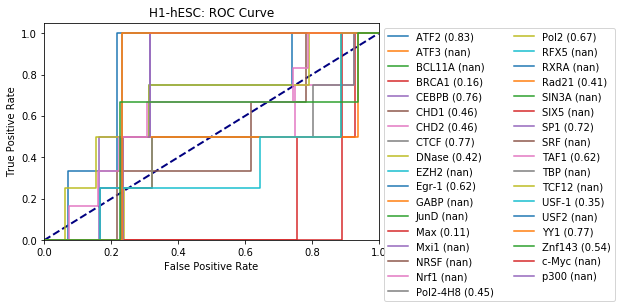

In [112]:
plt.figure()

lw = 2
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC Curve' % (dev_cell_type_1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))

for i in range(len(tfs)):
    tf_ = tfs[i]
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(labels_numpy[:,i], predictions_numpy[:,i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='%s (%0.2f)' % (tf_, roc_auc))

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2)
plt.show()

# Precision Recall plots on all TFs for H1-hESC

[2018-04-25 19:50:46,316] No handles with labels found to put in legend.
/data/akmorrow/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


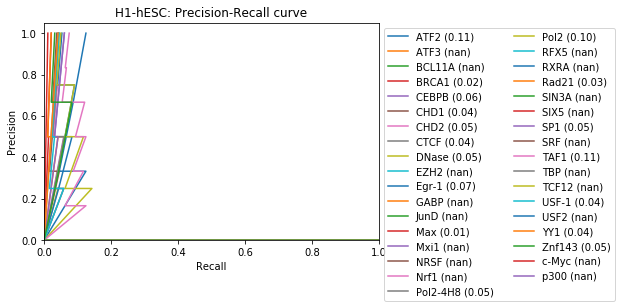

In [119]:
plt.figure()

lw = 2
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('%s: Precision-Recall curve' % (dev_cell_type_1))
plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))

for i in range(len(tfs)):
    tf_ = tfs[i]
    precision, recall, thresholds = precision_recall_curve(labels_numpy[:,i], predictions_numpy[:,i])
    auPRC = average_precision_score(labels_numpy[:,i], predictions_numpy[:,i])
    
    plt.plot(precision, recall, label='%s (%0.2f)' % (tf_, auPRC))

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2)
plt.show()



